# Evaluate land model output from perturbed parameter ensemble

This script evaluates model output from a set of ensemble members in a perturbed parameter experiment. It identifies the best-performing ensemble members

## Import modules

In [60]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import netCDF4 as nc4
import importlib
import esm_tools
importlib.reload(esm_tools)

<module 'esm_tools' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_tools.py'>

## Define paths and script parameters

In [75]:
# Benchmarking metrics
my_metrics = ["BA","AGB","TreeStemD","ShannonE","NPP","FailedPFTs"]

# Optional
case_path = None

# Path where case output lives
case_output_root = '/glade/scratch/adamhb/archive'

# Path to ensemble params
params_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles'

# Path to put any processed output
processed_output_root = '/glade/scratch/adamhb/processed_output'

# Path to param range files
param_range_root = '/glade/u/home/adamhb/california-fates/parameter_ranges/param_range_archive'

## Variables to import

In [55]:
# Keep first two no matter what. They are needed to unravel multi-plexed dimensions
fields = ['FATES_SEED_PROD_USTORY_SZ','FATES_VEGC_AP','FATES_BURNFRAC',
          'FATES_NPLANT_PF','FATES_NPLANT_SZPF','FATES_FIRE_INTENSITY_BURNFRAC','FATES_IGNITIONS',
          'FATES_MORTALITY_FIRE_SZPF','FATES_BASALAREA_SZPF','FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF','FATES_FUEL_AMOUNT_APFC','FATES_NPLANT_SZPF',
          'FATES_PATCHAREA_AP','FATES_CROWNAREA_PF','FATES_VEGC_ABOVEGROUND','FATES_NPP_PF']

In [8]:
full_case_path = esm_tools.get_path_to_sim('conifer-allom-082323a_-17e2acb6a_FATES-55794e61',
                                           case_output_root)

inst_tags = esm_tools.get_unique_inst_tags(full_case_path)
n_inst = len(inst_tags)
print("ninst:",n_inst)

# Generate some test data
inst_files = esm_tools.get_files_of_inst(full_case_path,inst_tags[0],last_n_years=1)
ds = esm_tools.multiple_netcdf_to_xarray(inst_files,fields)

# Test data extraction from netcdf
file_path = esm_tools.get_parameter_file_of_inst(params_root,'conifer_allom_082323a',"0001")
esm_tools.extract_variable_from_netcdf(file_path,"fates_allom_d2ca_coefficient_min",pft_index=1)

ninst: 36


## Benchmarking functions

In [82]:
def setup_benchmarking_data_structure(metrics,parameters,pft_names = pft_names):
    
    metrics_out = metrics.copy()
    
    # add pft-specific vars
    pft_specific_ba_metrics = ["BA_" + pft for pft in pft_names]  
    metrics_out.extend(pft_specific_ba_metrics)
    
    # add inst tag
    metrics_out.append("inst")    
    metrics_out.extend(parameters)
    
    benchmarking_dict = {}
    for i in metrics_out:
        benchmarking_dict[i] = []
    return benchmarking_dict

def get_benchmarks(case_name,metrics,last_n_years,param_sub_dir,param_range_file_name,
                   test = False, pft_names = np.array(["pine","cedar","fir","shrub","oak"]),
                   pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen'],
                   param_range_root = param_range_root,
                   params_root = params_root):
      
    print("Case:",case_name)
    
    # 1. Get info about the case
    full_case_path = esm_tools.get_path_to_sim(case_name,case_output_root)
    inst_tags = esm_tools.get_unique_inst_tags(full_case_path)
    
    if test == True:
        inst_tags = inst_tags[:3]
    
    n_inst = len(inst_tags)
    print("ninst:",n_inst)
    
    # 2. Set up the benchmarking data structure
    perturbed_params_df = pd.read_csv(os.path.join(param_range_root,param_range_file_name))
    perturbed_params = []
    for i in range(len(perturbed_params_df)):
        perturbed_params.append(perturbed_params_df['param'][i] + "_" + str(perturbed_params_df['pft'][i]))
    
    bench_dict = setup_benchmarking_data_structure(metrics,perturbed_params,pft_names)  
    print(bench_dict)
                                 
    # 3. Add param values to the data structure
    for inst in inst_tags:
        param_file_path = esm_tools.get_parameter_file_of_inst(params_root,param_sub_dir,inst)
        
        i = 0                      
        for param,pf in zip(perturbed_params_df['param'], perturbed_params_df['pft']):
            i = i + 1
            bench_dict[perturbed_params[i-1]].append(esm_tools.extract_variable_from_netcdf(
                                                           param_file_path,param,pf))
    
    # 4. Add the model output to the data structure
    for inst in inst_tags:
        
        print("Working on ensemble memeber",inst,"of",len(inst_tags),"members")
        
        # Import the model output data for one ensemble member
        inst_files = esm_tools.get_files_of_inst(full_case_path,
                                                 inst,
                                                 last_n_years)
        
        ds = esm_tools.multiple_netcdf_to_xarray(inst_files,fields)
        
        bench_dict['inst'].append(inst)
        
        ## Basal area [m2 ha-1] ##
        if "BA" in bench_dict.keys():
            
            ## Pft-specific BA
            pft_level_ba = esm_tools.get_pft_level_basal_area(ds)
            
            for i in range(len(pft_names)):
                pft_name = pft_names[i]
                bench_dict['BA_' + pft_name].append(pft_level_ba[i])
            
            ## Shannon equitability index (wrt BA) ##
            bench_dict['ShannonE'].append(esm_tools.shannon_equitability(pft_level_ba))
            
            ## Number of failed pfts ##
            bench_dict['FailedPFTs'].append(esm_tools.get_n_failed_pfts(pft_level_ba,ba_thresh=0.1))
            
            ## Total BA
            bench_dict['BA'].append(pft_level_ba.sum())
                  
        ## Stem density [N ha-1] ##
        if "TreeStemD" in bench_dict.keys():
            
            ## Total tree stem density
            bench_dict["TreeStemD"].append(esm_tools.get_total_stem_den(ds,trees_only=False,dbh_min=10))
        
        ## AGB [kg C m-2]
        if "AGB" in bench_dict.keys():
            bench_dict["AGB"].append(esm_tools.get_AGB(ds))
        
        ## Total NPP [kg C m-2]
        if "NPP" in bench_dict.keys():
            bench_dict["NPP"].append(esm_tools.get_total_npp(ds))        
            
        
    return bench_dict

## Apply to case

Case: conifer-allom-082323a_-17e2acb6a_FATES-55794e61
ninst: 3
{'BA': [], 'AGB': [], 'TreeStemD': [], 'ShannonE': [], 'NPP': [], 'FailedPFTs': [], 'BA_pine': [], 'BA_cedar': [], 'BA_fir': [], 'BA_shrub': [], 'BA_oak': [], 'inst': [], 'fates_allom_d2ca_coefficient_min_1': [], 'fates_mort_scalar_cstarvation_1': []}
Working on ensemble memeber 0001 of 3 members
Working on ensemble memeber 0002 of 3 members
Working on ensemble memeber 0003 of 3 members


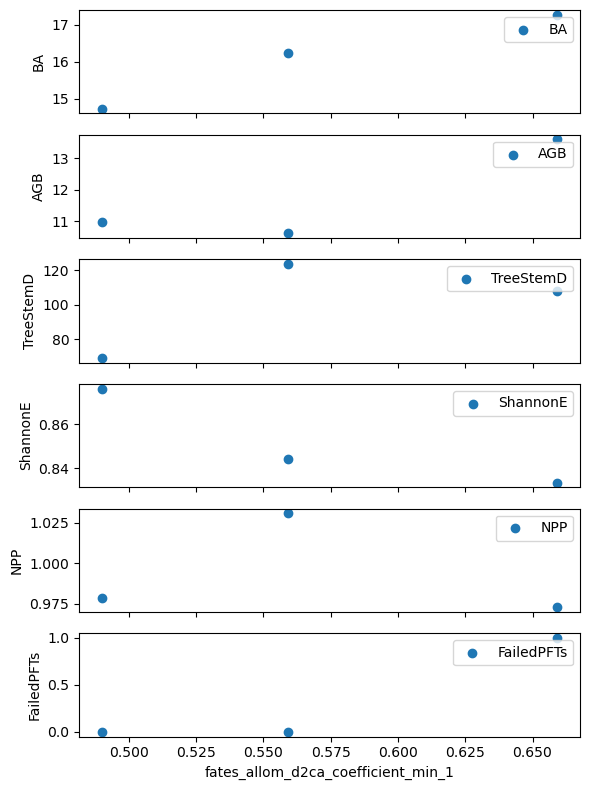

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-082323a_-17e2acb6a_FATES-55794e61' already exists!


<Figure size 640x480 with 0 Axes>

In [83]:
bench_dict_a = get_benchmarks(case_name='conifer-allom-082323a_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_082323a",
                              param_range_file_name = 'param_ranges_conifer_allom_test_082323.csv',
                              test=False)
bench_df_a = pd.DataFrame(bench_dict_a)
esm_tools.plot_multi_panel(df = bench_df_a, x_col = "fates_allom_d2ca_coefficient_min_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-082323a_-17e2acb6a_FATES-55794e61',bench_df_a,processed_output_root = processed_output_root)